In [136]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# print out floats gud
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

In [137]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# batch size
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

# number of "bins" for u-law
NBINS = 32

In [138]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [139]:
# read in 1000 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 100)

Reading in .wav files...


In [140]:
# waveform preprocessing
def preprocessWaveform(waveform):
    mn = np.min(waveform)
    mx = np.max(waveform)
    
    maxabs = max(abs(mn), abs(mx))
    scl = 32768.0 / maxabs    
    
    processed = waveform * scl
    
    return processed, (scl,)
    
def unpreprocessWaveform(waveform, params):
    unprocessed = waveform / params[0]
    return unprocessed



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
    processed /= 32768.0
    
    # apply u-law transformation
    processed = np.sign(processed) * np.log(1.0 + (NBINS - 1) * np.abs(processed)) / np.log(1.0 + (NBINS - 1))
    
    # scale from 0 to 255
    processed = ((processed + 1.0) / 2.0) * (NBINS - 1)
    
    # quantize into 255 bins
    processed = np.round(processed)
    processed = processed.astype(np.int16)
    
    return processed, ()

def unpreprocessWindows(windows, params):
    # de-quantize (go from ints [0, 255] to float [-1.0, 1.0])
    unprocessed = np.copy(windows)
    unprocessed = unprocessed.astype(np.float32)
    unprocessed = (unprocessed / (NBINS - 1)) * 2.0 - 1.0
    
    # un-apply u-law transformation
    unprocessed = np.sign(unprocessed) * (np.power(NBINS, np.abs(unprocessed)) - 1) / (NBINS - 1)
    
    # scale window from [-1, 1] to [-32768, 32768]
    unprocessed *= 32768.0
    return unprocessed

In [141]:
# test data preprocessing and loss
data = np.copy(rawWaveforms[55])

processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
transformed, tparams = preprocessWindows(windows)

print np.max(transformed)
print np.min(transformed)

desired = unpreprocessWindows(transformed, tparams)
desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
desired = unpreprocessWaveform(desired, wparams)

# trim desired down to length of data
if (desired.shape[0] > data.shape[0]):
    desired = desired[:data.shape[0]]
desired = np.round(desired)
    
sciwav.write("orig.wav", 16000, data.astype(np.int16))
sciwav.write("processed.wav", 16000, desired.astype(np.int16))

print "mean l1:", np.mean(np.abs(data - desired))
print "max l1: ", np.max(np.abs(data - desired))
print "means:", np.mean(data), np.mean(desired)
print "stds: ", np.std(data), np.std(desired)
print "max/min orig:  ", np.max(data), np.min(data)
print "max/min recons:", np.max(desired), np.min(desired)

31
1
mean l1: 9.93523877629
max l1:  149.0
means: 0.471988200854 0.773671
stds:  210.915280373 211.997
max/min orig:   1379.0 -1023.0
max/min recons: 1379.0 -1094.0


In [142]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [143]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (10116, 512)
Max:  32768.0
Min:  -32768.0


In [144]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (10116, 512)


In [145]:
processedWindows, pwParams = preprocessWindows(augWindows)

# reshape into (WINDOW_SIZE x 1) vector form for training
X_train = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))
ntrain = X_train.shape[0]

print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(10116, 512)
15.3692134135
4.26798436417
0
31


In [146]:
# empirically estimate prior probabilities
prior_probs = np.zeros(NBINS)

for w in processedWindows:
    for i in w:
        prior_probs[i] += 1

prior_probs /= sum(prior_probs)

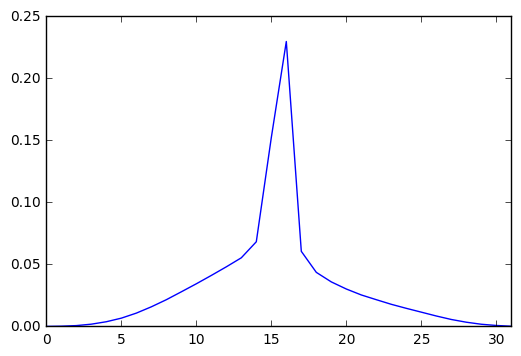

In [147]:
# plot probability distribution
from matplotlib import pyplot as plt

X = np.linspace(0, NBINS - 1, NBINS, endpoint=True)
plt.xlim(0.0, NBINS - 1)
plt.plot(prior_probs)
plt.show()

In [148]:
# define uniform probability distribution
uni_probs = np.zeros_like(prior_probs)
uni_probs[prior_probs != 0] = 1
uni_probs = uni_probs / np.sum(uni_probs)

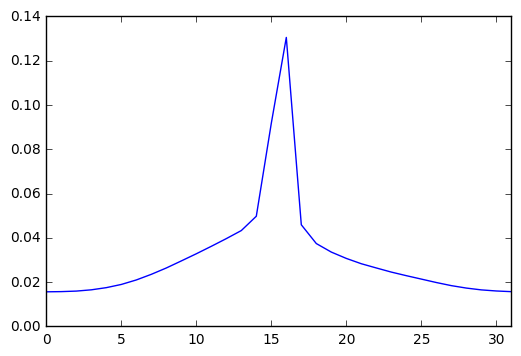

In [149]:
# convex combination of empirical prior and uniform distribution
gamma = 0.5
prior_mix = (1 - gamma) * prior_probs + gamma * uni_probs

# plot mix
X = np.linspace(0, NBINS - 1, NBINS, endpoint=True)
plt.xlim(0.0, NBINS - 1)
plt.plot(prior_mix)
plt.show()

In [150]:
# generate prior factors through reciprocal, normalizing s.t. E(p) = 1
prior_factors = np.array(prior_probs ** -1)
prior_factors /= np.sum(prior_probs * prior_factors)

print prior_probs
print prior_factors

[0.000028 0.000205 0.000683 0.001828 0.003792 0.006680 0.010738 0.015818
 0.021554 0.027922 0.034392 0.041133 0.048074 0.055354 0.068294 0.152265
 0.229795 0.060581 0.043618 0.035917 0.030195 0.025393 0.021577 0.017848
 0.014608 0.011526 0.008427 0.005616 0.003412 0.001770 0.000785 0.000172]
[1131.860140 152.550424 45.786704 17.096863 8.240721 4.678189 2.910189
 1.975588 1.449829 1.119205 0.908645 0.759723 0.650040 0.564552 0.457578
 0.205234 0.135991 0.515838 0.716440 0.870067 1.034931 1.230638 1.448324
 1.750911 2.139226 2.711201 3.708296 5.564165 9.159932 17.652525 39.797394
 181.656566]


In [151]:
# operations for binarization layer (THEANO ONLY)
class Binarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(Binarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(x)
        z[0][z[0] < 0] = -1
        z[0][z[0] >= 0] = 1
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        # (i don't think there's a mathematical justification for this?)
        return [output_gradients[0]]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

    
class BinarizeLayer(Layer):
    """ Binarizes input 
    <feedforward> binarizes output of tanh to -1 and 1
    <backward> returns delta unchanged
    """
    def __init__(self, **kwargs):
        super(BinarizeLayer, self).__init__(**kwargs)
        self.op = Binarize()
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        return self.op(x)

    #def get_output_shape_for(self, input_shape):
    #    return input_shape
    
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(BinarizeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [176]:
input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 320

def wregu():
    # return l2(0.001)
    return None

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc = Sequential()
    dec = Sequential()
    
    # based on architecture in this paper:
    #     http://arxiv.org/pdf/1602.02644.pdf
    # adapted to a 32x32 image instead of 64x64

    # (512x1) => (512x64)
    enc.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          input_shape = dim, activation = 'relu',
                          init = 'glorot_normal', bias = True))

    # (512x1) => (256x64)   
    enc.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          input_shape = dim, activation = 'relu',
                          init = 'glorot_normal', bias = True))
    enc.add(MaxPooling1D(2))
    
    # (256x64) => (128x64)    
    enc.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu',
                          init = 'glorot_normal', bias = True))
    enc.add(MaxPooling1D(2))
    
    # (128x64) => (64x64)
    enc.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu',
                          init = 'glorot_normal', bias = True))
    enc.add(MaxPooling1D(2))
    
    # (64x64) => (32x10)
    enc.add(Convolution1D(10, 9, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'relu',
                          init = 'glorot_normal', bias = True))
    enc.add(MaxPooling1D(2))
    
    # (32x10) => (32x10)
    enc.add(Convolution1D(10, 9, W_regularizer = wregu(), border_mode = 'same',
                          activation = 'linear',
                          init = 'glorot_normal', bias = True))
    
    # binarize   
    enc.add(Reshape((bottleneck_size,)))
    enc.add(BinarizeLayer())
    
    dec.add(Reshape((32, 10,), input_shape = (bottleneck_size,)))
    
    # (32x10) => (64x64)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'relu',
                          bias = True))
    
    # (64x64) => (128x64)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'relu',
                          bias = True))
    
    # (128x64) => (256x64)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'relu',
                          bias = True))
    
    # (256x64) => (512x64)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'relu',
                          bias = True))
    
    # (512x64) => (512x64)
    dec.add(Convolution1D(64, 9, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'relu',
                          bias = True))
    
    # (512x64) => (512x256) where each 256-len vector is a softmax
    dec.add(Convolution1D(NBINS, 1, W_regularizer = wregu(), border_mode = 'same',
                          init = 'glorot_normal', activation = 'softmax',
                          bias = True))

    return enc, dec


def onehot_acc_strict(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = K.argmax(y_pred, axis = 2)
    true_vec = K.argmax(y_true, axis = 2)
    
    equal = K.equal(pred_vec, true_vec)
    return K.mean(equal)

def onehot_acc_loose(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = K.argmax(y_pred, axis = 2)
    true_vec = K.argmax(y_true, axis = 2)
    
    diff = K.abs(pred_vec - true_vec)
    almost = K.lesser_equal(diff, 2)
    return K.mean(almost)

def onehot_rmse(y_true, y_pred):
    # convert one-hot vectors to actual vectors
    pred_vec = K.argmax(y_pred, axis = 2)
    true_vec = K.argmax(y_true, axis = 2)
    
    return K.sqrt(K.mean(K.square(pred_vec - true_vec)))

k_prior_factors = K.variable(prior_factors)
def weighted_categorical_crossentropy(y_true, y_pred):
    true_vec = K.argmax(y_true, axis = 2)
    weights = k_prior_factors[true_vec]
    
    return weights * -K.sum(y_true * K.log(y_pred), axis = -1)
    #return -K.sum(y_true * K.log(y_pred), axis = 2)



all_metrics = [onehot_acc_strict, onehot_acc_loose, onehot_rmse]

# plain autoencoder
inp = Input(shape = input_dim)
enc, dec = autoencoder_structure(input_dim)
embedding = enc(inp)
recons = dec(embedding)
autoencoder = Model(input = inp, output = recons)
autoencoder.compile(loss = weighted_categorical_crossentropy,
              optimizer = Adam())
autoencoder.summary()

losses = [weighted_categorical_crossentropy]
lweights = [1.0]

# compile another model (in case i want to do other stuff during training)
model = Model(input = inp, output = [recons] * len(losses))
model.compile(loss = losses, loss_weights = lweights,
              optimizer = Adam(), metrics = all_metrics)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_41 (Sequential)       (None, 320)           118104      input_21[0][0]                   
____________________________________________________________________________________________________
sequential_42 (Sequential)       (None, 512, 32)       155616      sequential_41[1][0]              
Total params: 273720
____________________________________________________________________________________________________


In [177]:
import scipy

# turns quantized windows to one-hot vectors
#     (optimized function ;) 
def windows_to_one_hot(windows, soft = False, sz = 3, std = 0.5):
    one_hot = np.zeros((windows.shape[0], windows.shape[1], NBINS))
    
    if (soft):
        # soft one-hot vector
        kernel = scipy.signal.gaussian(sz, std)
        kernel /= sum(kernel)
        
        # for each window in windows
        for i in xrange(0, windows.shape[0]):
            # this is really hacky, but it's the fastest way to do this
            # special convolution
            for j in xrange(-sz/2, (sz/2)+1):
                try:
                    one_hot[i, np.arange(windows[i].shape[0]),
                            np.where(windows[i] + j < 0, NBINS+1, windows[i] + j)] = kernel[j+4]
                except:
                    pass
    else:
        # for each window in windows
        for i in xrange(0, windows.shape[0]):
            # set indices to 1
            one_hot[i, np.arange(windows[i].shape[0]), windows[i]] = 1
    
    return one_hot
    
# turns one-hot-vectors into quantized (by taking argmax)
def one_hot_to_windows(one_hot):
    return np.array([[np.argmax(v) for v in w] for w in one_hot])

kernel = scipy.signal.gaussian(3, 0.5)
kernel / sum(kernel)

array([0.106507, 0.786986, 0.106507])

In [178]:
def autoencoderTest(waveFilename, prefix, autoencoder):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    print transformed.shape
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    sciwav.write(prefix + "desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)
    print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE, NBINS))
    autoencOutput = one_hot_to_windows(autoencOutput)
    
    print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    print "Max desired:", np.max(desired)
    print "Min desired:", np.min(desired)
    print "Max recons: ", np.max(recons)
    print "Min recons: ", np.min(recons)
    
    sciwav.write(prefix + "output.wav", rate, recons.astype(np.int16))

    print waveFilename, " mse: ", mse(recons, desired)
    print waveFilename, " avg err: ", avgErr(recons, desired)

In [179]:
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 300

lead = "    "

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    totalLosses = []
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        batch_onehot = windows_to_one_hot(batch[:, :, 0], True)
        
        batchLosses = model.train_on_batch(batch, [batch_onehot] * len(lweights))
        if (len(lweights) > 1):
            numMetrics = len(lweights) + len(all_metrics) + 1
            batchLosses = batchLosses[:numMetrics]
        
        if (totalLosses == []):
            totalLosses = np.array(batchLosses)
        else:
            totalLosses += np.array(batchLosses)
        
        avgLosses = totalLosses / (i + 1)
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(avgLosses)
            print printStr,
            
        i += 1
    print ""
    
    # print elapsed time
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    print ""

Epoch 1:
    9600: [0.517719 0.016541 0.026852 13.514443] 
    Total time for epoch: 32.8159089088s

Epoch 2:
    9600: [0.508737 0.020360 0.024727 13.855727] 
    Total time for epoch: 22.6328561306s

Epoch 3:
    9600: [0.506588 0.019530 0.023872 13.860289] 
    Total time for epoch: 22.7408738136s

Epoch 4:
    9600: [0.509312 0.019847 0.024200 13.859035] 
    Total time for epoch: 22.7504708767s

Epoch 5:
    9600: [0.508169 0.020356 0.024693 13.854108] 
    Total time for epoch: 22.7482681274s

Epoch 6:
    6400: [0.500404 0.019762 0.023993 13.861156]

KeyboardInterrupt: 

In [180]:
autoencoderTest("./SA1.WAV", "SA1_aac_", autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_", autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_", autoencoder)

 (112, 512)
112/112 [==============================] - 0s     
(112, 512, 32)
(112, 512)
Max desired: 4899.0
Min desired: -3885.76
Max recons:  -4777.02
Min recons:  -4899.0
./SA1.WAV  mse:  2.41194e+07
./SA1.WAV  avg err:  4895.15
(93, 512)
93/93 [==============================] - 0s     
(93, 512, 32)
(93, 512)
Max desired: 3057.0
Min desired: -3057.0
Max recons:  -2980.88
Min recons:  -3057.0
./SX383.WAV  mse:  9.4274e+06
./SX383.WAV  avg err:  3054.29
(183, 512)
183/183 [==============================] - 0s     
(183, 512, 32)
(183, 512)
Max desired: 21275.0
Min desired: -21275.0
Max recons:  -20745.3
Min recons:  -21275.0
./fiveYears.wav  mse:  4.71369e+08
./fiveYears.wav  avg err:  21254.1
